In [9]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib import rc, rcParams
from matplotlib.colors import LinearSegmentedColormap as colormap
from IPython.display import HTML
import math
import os, sys
from functools import reduce
import operator
sys.path.append(os.path.relpath("../src"))
from kitaev_chain import kitaev_chain_model, quench_simulation, U
FFwriter=FFMpegWriter(fps=30, extra_args=['-vcodec', 'libx264'])
from utils import gamma_n, sy
rcParams.update({ "text.usetex": True, "font.family": "serif", "text.latex.preamble": r"\usepackage{amsmath}" })

In [10]:
def fermion_chain_from_spin_chain_params_parrallel_field(n_sites, J, h_z, h_edges_x):
    n = n_sites + 2
    mu = -np.ones(n) * h_z; mu[0] = mu[-1] = 0
    t = np.ones(n - 1) * J
    t[0] = h_edges_x
    t[-1] = h_edges_x
    t *= .5
    delta = -t
    return kitaev_chain_model(n, mu, t, delta, True)
def fermion_chain_from_spin_chain_params(n, J, h_z, h_edges_x):
    mu = -np.ones(n) * h_z
    t = np.ones(n - 1) * J
    t *= .5
    delta = -t
    return kitaev_chain_model(n, mu, t, delta, False)

def are_bdg_conj(state1, state2):
    l = len(state1) // 2
    return np.allclose(np.abs(state1[[list(range(l, 2 * l)) + list(range(l))]] @ state2), np.ones(1))

def log_progress(element, process, fraction_done):
    print(f"{process}: {fraction_done * 100 : .2f}%", end='\r')
    return element



In [11]:
n = 60
m = n + 2
H0 = fermion_chain_from_spin_chain_params_parrallel_field(n, 1, 1, h_edges_x=200)
H = fermion_chain_from_spin_chain_params_parrallel_field(n, 1, 1, h_edges_x=0)
H0.bdg_eigen()
H.bdg_eigen()
u = U(H)
G_D = gamma_n(m).conj().T
[i for (i, v) in enumerate([are_bdg_conj(H0.bdg_evecs_sorted[:, i], H0.bdg_evecs_sorted[:, i + m]) for i in range(m)]) if not v]

[0, 60, 61]

In [12]:
high_energy_states = H0.bdg_evecs_sorted[:,[m - 2, m - 1, 2 * m - 2,2 * m - 1]]
if are_bdg_conj(H0.bdg_evecs_sorted[:, m - 2], H0.bdg_evecs_sorted[:, 2 * m - 1]):
    high_energy_states = H0.bdg_evecs_sorted[:,[m - 2, m - 1, 2 * m - 1,2 * m - 2]]

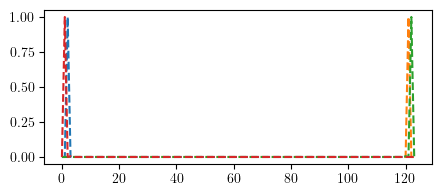

In [13]:
high_energy_maj = 0.5 ** 0.5 * np.hstack(
    [high_energy_states[:, :2] + high_energy_states[:, 2:],
     1j * (high_energy_states[:, :2] - high_energy_states[:, 2:])])
high_energy_maj = high_energy_maj[:,np.argsort(np.argmax(np.abs(high_energy_maj.T), axis=1))]
plt.gcf().set_size_inches((5,2))
for line in (G_D@(high_energy_maj)).T:
    plt.plot(np.abs(line), '--')


In [14]:
U = H0.U.T.conj()
V = H0.V.T.conj()
G = np.block(([[U @ U.conj().T, U @ V.conj().T],
               [V @ U.conj().T, np.eye(m) - U.conj() @ U.T]]))
G_sites = lambda G, start, end: G[list(range(start, end)) + list(range(start + m, end + m))][:,
                               list(range(start, end)) + list(range(start + m, end + m))]

In [15]:
g = G_sites(G, 1, m - 1)
f = 2 * g - np.eye(len(g))
Ex = np.block([[0 * np.eye(len(g) // 2), 1 * np.eye(len(g) // 2)],
               [1 * np.eye(len(g) // 2), 0 * np.eye(len(g) // 2)]])
np.allclose(Ex @ f @ Ex, -f) and np.allclose(Ex @ g.T @ Ex, np.eye(len(g)) - g)

True

In [16]:
cycle = 1.92 * m
duration = 10 * cycle
dt = m / 20
t_range = np.arange(0, duration, dt)

u_gamma_sim = [
    np.vstack([G_D@(u(t) @
                    maj
                    ) for t in t_range]).T
for maj in high_energy_maj.T
]

loschmidt_sim = np.array([np.abs(
            np.linalg.det(
                H0.bdg_evecs_sorted[:, m:].T.conj() @ u(t) @ H0.bdg_evecs_sorted[:, m:]
                )
            ) for t in t_range])

G_sim = [G_sites(u(t) @ G @ u(t).conj().T, 0, m) for t in t_range]

braid_sim = []

entropy_sim = -0.5 * np.array([
       log_progress(
        [
            (lambda g:
                (lambda v:
                    -np.sum( (v @ np.log(v) + (1 - v) @ np.log(1 - v)))
                )(np.clip(np.linalg.eigvals(g), 1e-4, 1 - 1e-4))
            )(G_sites(G, 1, k)) for k in range(1, m - 1)
        ]
    , 'bdg entropy', i / len(G_sim))
     for i, G in enumerate(G_sim) ])

B_23_bdg = np.eye(2*m).astype(complex)
B_23_bdg[2 : -2 : 2 * m - 5, 2 : -2 : 2 * m - 5] *= -1
B_23_bdg = G_D.conj().T @ B_23_bdg @ G_D
G_B23 = B_23_bdg @ G @ B_23_bdg.T.conj()
braid_bdg_sim = np.array([np.abs(
            np.linalg.det(
                H0.bdg_evecs_sorted[:, m:].T.conj() @ B_23_bdg.T.conj() @ u(t) @ H0.bdg_evecs_sorted[:, m:]
                )
            ) for t in t_range])


In [17]:
gamma_sim_ = [u_gamma_sim[i] for i in [2, 0, 3, 1]]
color = np.array([
    [0, 0.5, 1],
    [1, 0, 0],
    [0, 1, 0],
    [0.9, 0.6, 0]
    ])

image = np.permute_dims(
    (
        reduce(
            operator.mul,
               [
                   np.ones((3, *tuple(np.shape(gamma_sim_[i])))) -
                   np.kron(
                       (np.ones(3) - color[i]).reshape((3, 1, 1)),
                       np.abs(gamma_sim_[i])
                    )
                    for i in range(4)])),
    (1,2,0))
image = image[1:-1,:,:]

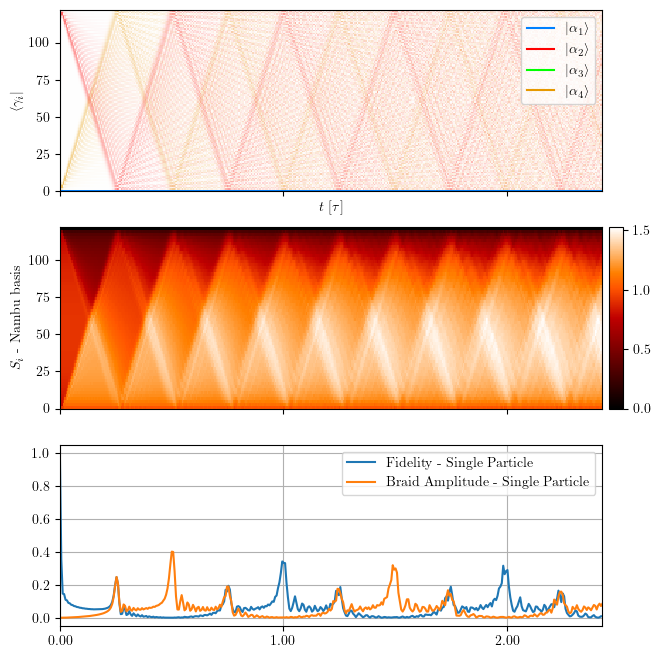

In [18]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True)
fig.set_size_inches(7, 8)
t_range_ = t_range / cycle / 4 * 0.973
xmin, xmax = t_range_[0], t_range_[-1]
ax0.imshow(image, aspect='auto', interpolation='nearest', extent=(xmin, xmax, 0, image.shape[0]), origin='upper')
#color = color[[3, 1, 2, 0]]
for i in range(4):
    ax0.plot([],[],color=color[i],label='$|\\alpha_'+f'{i+1}'+'\\rangle$')
ax0.legend()
ax0.set_ylabel("$\\langle\\gamma_i|$")

im = ax1.imshow(np.abs(entropy_sim).T, aspect='auto', interpolation='nearest', extent=(xmin, xmax, 0, image.shape[0]), origin='upper', cmap='gist_heat')
pos = ax1.get_position()  # Bbox in figure coordinates
cbar_width = 0.02         # width in figure coords (adjust if needed)
pad = 0.01                # gap between ax1 and colorbar in figure coords
cax = fig.add_axes([pos.x1 + pad, pos.y0, cbar_width, pos.height])
cbar = fig.colorbar(im, cax=cax)
ax1.set_ylabel("$S_{i}$ - Nambu basis")

ax2.plot(t_range_, np.abs(loschmidt_sim), label="Fidelity - Single Particle")
ax2.plot(t_range_, np.abs(braid_bdg_sim), label="Braid Amplitude - Single Particle")
ax2.legend()
ax2.grid()
ax2.set_xlim(xmin, xmax)
ax0.set_xlabel('$t \\ [\\tau]$')
#ax0.set_title(f"Braid on a {n} sites chain")

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

step = 1
locator = MultipleLocator(step)
fmt = FormatStrFormatter('%.2f')

for ax in (ax0, ax1, ax2):
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(fmt)

plt.savefig(f"../simulations/braid on {n} sites chain - long.png")
pass